# Anderson model of localization

## parameter choices

In [1]:
myseed= 111111
width= 20
nimages= 5000
img_sizeX= 100
img_sizeY= img_sizeX

validation_split= 0.1
batch_size= 64
myepochs= num_epochs =30
mylr= 0.01
mywd= 1e-6

dataname='L'+str(width)+'-'+str(nimages)+'-s'+str(img_sizeX)

datapath = '/storage/disqs/'+'ML-Anderson3D/Images/'+dataname # SC-RTP
#datapath = '/mnt/DataDrive/'+'ML-Data/Anderson/Images/'+dataname # Ubuntu home RAR
    
print(dataname,"\n",datapath)

method='Keras-Resnet50-'+str(myseed)+'-e'+str(num_epochs) #+'-bs'+str(batch_size)
modelname = 'Model_'+method+'_'+dataname+'.pth'
historyname = 'History_'+method+'_'+dataname+'.pkl'
print(method,"\n",modelname,"\n",historyname)

savepath = './'+dataname+'/'
import os
try:
    os.mkdir(savepath)
except FileExistsError:
    pass

modelpath = savepath+modelname
historypath = savepath+historyname
print(savepath,modelpath,historypath)

L20-5000-s100 
 /storage/disqs/ML-Anderson3D/Images/L20-5000-s100
Keras-Resnet50-111111-e30 
 Model_Keras-Resnet50-111111-e30_L20-5000-s100.pth 
 History_Keras-Resnet50-111111-e30_L20-5000-s100.pkl
./L20-5000-s100/ ./L20-5000-s100/Model_Keras-Resnet50-111111-e30_L20-5000-s100.pth ./L20-5000-s100/History_Keras-Resnet50-111111-e30_L20-5000-s100.pkl


## initializations

In [2]:
#standard notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#standard libraries
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

import random as rn
import os
import matplotlib.pyplot as plt
sys.path.insert(0,'../../../../PyCode/')
#np.random.seed(1337) # for reproducibility
#np.random.seed(2000) 

In [4]:
#machine learning libraries
import tensorflow as tf 
import keras
print("tensorflow: ",tf.__version__, ", keras: ", keras.__version__)

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
print("sklearn: ", sklearn.__version__)

Using TensorFlow backend.


tensorflow:  2.1.0 , keras:  2.3.1
sklearn:  0.21.3


In [5]:
#special subroutines
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, Flatten
from keras.layers import Dropout
from keras import optimizers
from keras.models import load_model

# from tensorflow.keras.layers import Dense, Conv2D
# from tensorflow.keras.layers import Conv1D, MaxPooling2D
# from tensorflow.keras.layers import AveragePooling2D, Flatten
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.models import Sequential


# from tensorflow.keras.utils import to_categorical

# import numpy

## starting the main code

In [6]:
np.random.seed(myseed) # necessary for starting Numpy generated random numbers in a well-defined initial state.
rn.seed(myseed+1) # necessary for starting core Python generated random numbers in a well-defined state.

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

os.environ['PYTHONHASHSEED'] = '0'

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v2.random.set_seed(myseed+3)
#tf.set_random_seed(1234)

#sess = tf.compat.v2.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

## reading the images

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,validation_split=validation_split)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
training_set = train_datagen.flow_from_directory(datapath,
                                                 subset='training',
                                                 target_size = (img_sizeX,img_sizeY),
                                                 batch_size = batch_size, 
                                                 class_mode='categorical',
                                                shuffle=True,seed=myseed)

validation_set= train_datagen.flow_from_directory(datapath, 
                                              subset='validation', 
                                              target_size = (img_sizeX,img_sizeY),
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                                 shuffle=False,seed=myseed)

# test_set = test_datagen.flow_from_directory('data-keras-L20-100/test_set',
#                                             target_size = (171, 171),
#                                             batch_size = batch_size,
#                                             class_mode='categorical',
#                                            shuffle=False)

Found 76500 images belonging to 18 classes.
Found 8500 images belonging to 18 classes.


In [9]:
# X_train, X_labels = next(training_set)
# Y_train, Y_labels = next(validation_set)
# len(X_train),len(X_labels),len(Y_train),len(Y_labels)

In [10]:
num_of_train_samples = training_set.samples
num_of_test_samples = validation_set.samples
num_classes = len(validation_set.class_indices)

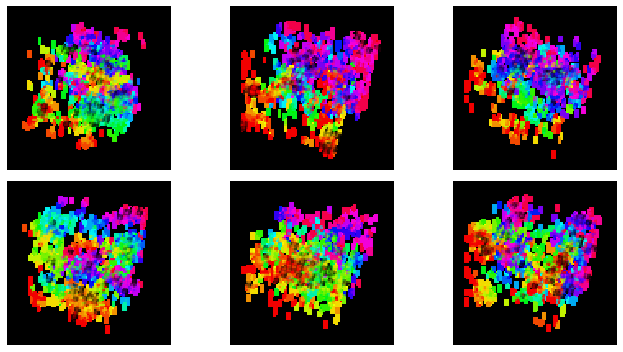

In [11]:
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in validation_set:
        plt.imshow(x[0],cmap='hsv')
        #plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

## building the CNN

In [12]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(img_sizeX, img_sizeY, 3))

def create_CNN():
    # instantiate model
    model= Sequential([
        resnet,Flatten(),
        Dense(num_classes, activation='sigmoid'),
    ])
    
    return model

print('CNN architecture (Resnet50) created successfully!')

/warwick/desktop/2018/software/TensorFlow/2.1.0-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


CNN architecture (Resnet50) created successfully!


In [13]:
# Choose the Optimizer and the Cost Function

opt = optimizers.SGD(lr=mylr, decay=mywd)
#opt = keras.optimizers.Adam(lr=mylr, decay=mywd)

def compile_model(optimizer=opt):
    # create the mode
    model=create_CNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy','categorical_crossentropy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


In [14]:
# opt = optimizers.SGD(lr=mylr, decay=mywd)
# model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# create the deep neural net
model = compile_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                589842    
Total params: 24,177,554
Trainable params: 24,124,434
Non-trainable params: 53,120
_________________________________________________________________
None


## learning the images

In [15]:
# train DNN and store training info in history
history = model.fit_generator(training_set,
                         steps_per_epoch = training_set.samples // batch_size,
                         epochs = myepochs,
                         validation_data = validation_set,
                         validation_steps = validation_set.samples // batch_size)

Epoch 1/30
1195/1195 [==============================] - 547s 458ms/step - loss: 2.8856 - accuracy: 0.0559 - categorical_crossentropy: 2.8856 - val_loss: 2.8811 - val_accuracy: 0.0592 - val_categorical_crossentropy: 2.8809
Epoch 2/30
1195/1195 [==============================] - 375s 314ms/step - loss: 2.8765 - accuracy: 0.0567 - categorical_crossentropy: 2.8765 - val_loss: 2.8724 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8724
Epoch 3/30
1195/1195 [==============================] - 518s 433ms/step - loss: 2.8687 - accuracy: 0.0555 - categorical_crossentropy: 2.8688 - val_loss: 2.8655 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8653
Epoch 4/30
1195/1195 [==============================] - 533s 446ms/step - loss: 2.8625 - accuracy: 0.0566 - categorical_crossentropy: 2.8625 - val_loss: 2.8600 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8598
Epoch 5/30
1074/1195 [=========================>....] - ETA: 41s - loss: 2.8578 - accuracy: 0.0579 - categorical

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 780 could not be retrieved. It could be because a worker has died.
  UserWarning)


1075/1195 [=========================>....] - ETA: 51s - loss: 2.8577 - accuracy: 0.0579 - categorical_crossentropy: 2.8578

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 558 could not be retrieved. It could be because a worker has died.
  UserWarning)


1195/1195 [==============================] - 826s 691ms/step - loss: 2.8575 - accuracy: 0.0574 - categorical_crossentropy: 2.8575 - val_loss: 2.8559 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8555
Epoch 6/30
 645/1195 [===============>..............] - ETA: 4:29 - loss: 2.8545 - accuracy: 0.0585 - categorical_crossentropy: 2.8545

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 1045 could not be retrieved. It could be because a worker has died.
  UserWarning)


 646/1195 [===============>..............] - ETA: 5:21 - loss: 2.8545 - accuracy: 0.0586 - categorical_crossentropy: 2.8545

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 585 could not be retrieved. It could be because a worker has died.
  UserWarning)


1195/1195 [==============================] - 867s 725ms/step - loss: 2.8537 - accuracy: 0.0567 - categorical_crossentropy: 2.8537 - val_loss: 2.8523 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8521
Epoch 7/30
1195/1195 [==============================] - 430s 360ms/step - loss: 2.8508 - accuracy: 0.0578 - categorical_crossentropy: 2.8508 - val_loss: 2.8495 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8495
Epoch 8/30
1079/1195 [==========================>...] - ETA: 35s - loss: 2.8486 - accuracy: 0.0567 - categorical_crossentropy: 2.8486

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 1107 could not be retrieved. It could be because a worker has died.
  UserWarning)


1080/1195 [==========================>...] - ETA: 39s - loss: 2.8486 - accuracy: 0.0567 - categorical_crossentropy: 2.8486

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 60 could not be retrieved. It could be because a worker has died.
  UserWarning)


1081/1195 [==========================>...] - ETA: 46s - loss: 2.8486 - accuracy: 0.0566 - categorical_crossentropy: 2.8486

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 417 could not be retrieved. It could be because a worker has died.
  UserWarning)


1195/1195 [==============================] - 673s 563ms/step - loss: 2.8485 - accuracy: 0.0562 - categorical_crossentropy: 2.8485 - val_loss: 2.8476 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8474
Epoch 9/30
1195/1195 [==============================] - 515s 431ms/step - loss: 2.8466 - accuracy: 0.0576 - categorical_crossentropy: 2.8466 - val_loss: 2.8459 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8458
Epoch 10/30
 203/1195 [====>.........................] - ETA: 3:32 - loss: 2.8457 - accuracy: 0.0589 - categorical_crossentropy: 2.8457

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 463 could not be retrieved. It could be because a worker has died.
  UserWarning)


1195/1195 [==============================] - 403s 337ms/step - loss: 2.8451 - accuracy: 0.0571 - categorical_crossentropy: 2.8451 - val_loss: 2.8446 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8445
Epoch 11/30
1195/1195 [==============================] - 342s 286ms/step - loss: 2.8439 - accuracy: 0.0569 - categorical_crossentropy: 2.8439 - val_loss: 2.8435 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8433
Epoch 12/30
 129/1195 [==>...........................] - ETA: 11:04 - loss: 2.8433 - accuracy: 0.0555 - categorical_crossentropy: 2.8433

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 703 could not be retrieved. It could be because a worker has died.
  UserWarning)


 130/1195 [==>...........................] - ETA: 15:31 - loss: 2.8433 - accuracy: 0.0552 - categorical_crossentropy: 2.8433

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 716 could not be retrieved. It could be because a worker has died.
  UserWarning)


 932/1195 [======================>.......] - ETA: 2:38 - loss: 2.8430 - accuracy: 0.0571 - categorical_crossentropy: 2.8430

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 224 could not be retrieved. It could be because a worker has died.
  UserWarning)


 939/1195 [======================>.......] - ETA: 2:49 - loss: 2.8430 - accuracy: 0.0571 - categorical_crossentropy: 2.8430

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 1124 could not be retrieved. It could be because a worker has died.
  UserWarning)


1195/1195 [==============================] - 1199s 1s/step - loss: 2.8429 - accuracy: 0.0565 - categorical_crossentropy: 2.8429 - val_loss: 2.8425 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8424
Epoch 13/30
 773/1195 [==================>...........] - ETA: 8:24 - loss: 2.8422 - accuracy: 0.0576 - categorical_crossentropy: 2.8422

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 669 could not be retrieved. It could be because a worker has died.
  UserWarning)


1195/1195 [==============================] - 1643s 1s/step - loss: 2.8420 - accuracy: 0.0559 - categorical_crossentropy: 2.8420 - val_loss: 2.8416 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8416
Epoch 14/30
 179/1195 [===>..........................] - ETA: 28:36 - loss: 2.8416 - accuracy: 0.0566 - categorical_crossentropy: 2.8416

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 517 could not be retrieved. It could be because a worker has died.
  UserWarning)


 187/1195 [===>..........................] - ETA: 32:30 - loss: 2.8416 - accuracy: 0.0568 - categorical_crossentropy: 2.8416

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 65 could not be retrieved. It could be because a worker has died.
  UserWarning)


 847/1195 [====================>.........] - ETA: 12:22 - loss: 2.8414 - accuracy: 0.0575 - categorical_crossentropy: 2.8414

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 40 could not be retrieved. It could be because a worker has died.
  UserWarning)


1195/1195 [==============================] - 2685s 2s/step - loss: 2.8413 - accuracy: 0.0572 - categorical_crossentropy: 2.8413 - val_loss: 2.8411 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8410
Epoch 15/30
  36/1195 [..............................] - ETA: 47:19 - loss: 2.8410 - accuracy: 0.0530 - categorical_crossentropy: 2.8410

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 1052 could not be retrieved. It could be because a worker has died.
  UserWarning)


1195/1195 [==============================] - 2240s 2s/step - loss: 2.8407 - accuracy: 0.0567 - categorical_crossentropy: 2.8407 - val_loss: 2.8401 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8404
Epoch 16/30
1155/1195 [===========================>..] - ETA: 50s - loss: 2.8402 - accuracy: 0.0558 - categorical_crossentropy: 2.8402

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 359 could not be retrieved. It could be because a worker has died.
  UserWarning)


1171/1195 [============================>.] - ETA: 31s - loss: 2.8402 - accuracy: 0.0557 - categorical_crossentropy: 2.8402

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 758 could not be retrieved. It could be because a worker has died.
  UserWarning)


1195/1195 [==============================] - 1805s 2s/step - loss: 2.8402 - accuracy: 0.0557 - categorical_crossentropy: 2.8402 - val_loss: 2.8401 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8399
Epoch 17/30
1195/1195 [==============================] - 1554s 1s/step - loss: 2.8397 - accuracy: 0.0571 - categorical_crossentropy: 2.8397 - val_loss: 2.8395 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8395
Epoch 18/30
 368/1195 [========>.....................] - ETA: 23:12 - loss: 2.8394 - accuracy: 0.0565 - categorical_crossentropy: 2.8394

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 657 could not be retrieved. It could be because a worker has died.
  UserWarning)


 412/1195 [=========>....................] - ETA: 25:15 - loss: 2.8394 - accuracy: 0.0574 - categorical_crossentropy: 2.8394

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 121 could not be retrieved. It could be because a worker has died.
  UserWarning)


 548/1195 [============>.................] - ETA: 21:42 - loss: 2.8394 - accuracy: 0.0576 - categorical_crossentropy: 2.8394

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 672 could not be retrieved. It could be because a worker has died.
  UserWarning)


 944/1195 [======================>.......] - ETA: 8:52 - loss: 2.8393 - accuracy: 0.0573 - categorical_crossentropy: 2.8393

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 726 could not be retrieved. It could be because a worker has died.
  UserWarning)


1195/1195 [==============================] - 2716s 2s/step - loss: 2.8393 - accuracy: 0.0570 - categorical_crossentropy: 2.8393 - val_loss: 2.8391 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8391
Epoch 19/30
 707/1195 [================>.............] - ETA: 10:29 - loss: 2.8390 - accuracy: 0.0569 - categorical_crossentropy: 2.8390

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 841 could not be retrieved. It could be because a worker has died.
  UserWarning)


 715/1195 [================>.............] - ETA: 10:51 - loss: 2.8390 - accuracy: 0.0568 - categorical_crossentropy: 2.8390

/warwick/desktop/2018/software/Keras/2.3.1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 255 could not be retrieved. It could be because a worker has died.
  UserWarning)


1195/1195 [==============================] - 1629s 1s/step - loss: 2.8389 - accuracy: 0.0562 - categorical_crossentropy: 2.8389 - val_loss: 2.8393 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8387
Epoch 20/30
1195/1195 [==============================] - 962s 805ms/step - loss: 2.8386 - accuracy: 0.0570 - categorical_crossentropy: 2.8386 - val_loss: 2.8387 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8384
Epoch 21/30
1195/1195 [==============================] - 933s 781ms/step - loss: 2.8383 - accuracy: 0.0565 - categorical_crossentropy: 2.8383 - val_loss: 2.8381 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8382
Epoch 22/30
1195/1195 [==============================] - 1142s 956ms/step - loss: 2.8380 - accuracy: 0.0559 - categorical_crossentropy: 2.8380 - val_loss: 2.8378 - val_accuracy: 0.0593 - val_categorical_crossentropy: 2.8379
Epoch 23/30
1195/1195 [==============================] - 1074s 898ms/step - loss: 2.8378 - accuracy: 0.0564 - categorical

In [16]:
# tf.keras.models.save_model(history,'Anderson_Ohtsuki_model_L20_500_keras_SGD_0_01_good_input_size.h5') 
model.save(modelpath) 

import pickle 
f=open(historypath,"wb")
pickle.dump(history,f)
f.close()

## testing the quality of the learned model

In [17]:
#history = load_model(modelpath)

### training history

133/133 [==============================] - 15s 115ms/step

Test loss: 2.8365321159362793
Test accuracy: 0.05882352963089943


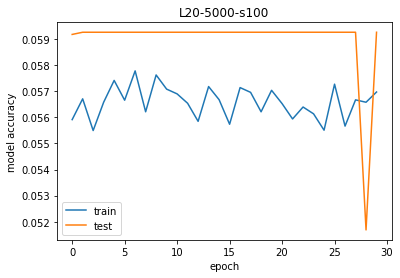

In [18]:
# evaluate model
score=model.evaluate(validation_set,verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
fig=plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(savepath+'/'+method+'_'+dataname+'_accuracy'+'.png')

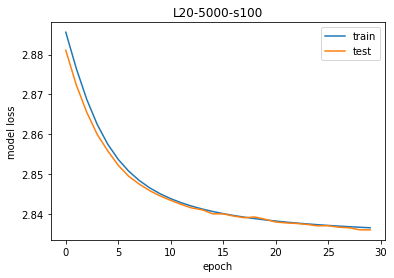

In [19]:
# summarize history for loss
fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(savepath+'/'+method+'_'+dataname+'_loss'+'.png')

### confusion matrix

In [20]:
validation_set.reset()
label=validation_set.class_indices.keys()

#Confusion Matrix 
Y_pred = model.predict_generator(validation_set, num_of_test_samples // batch_size+1, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

#basic confusion matrix
confusion_matrix(validation_set.classes, y_pred)

133/133 [==============================] - 7s 50ms/step


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         

/storage/disqs/ML-Anderson3D/ML-Anderson3D/ImageBased/Keras/3D/SCRTP-RAR


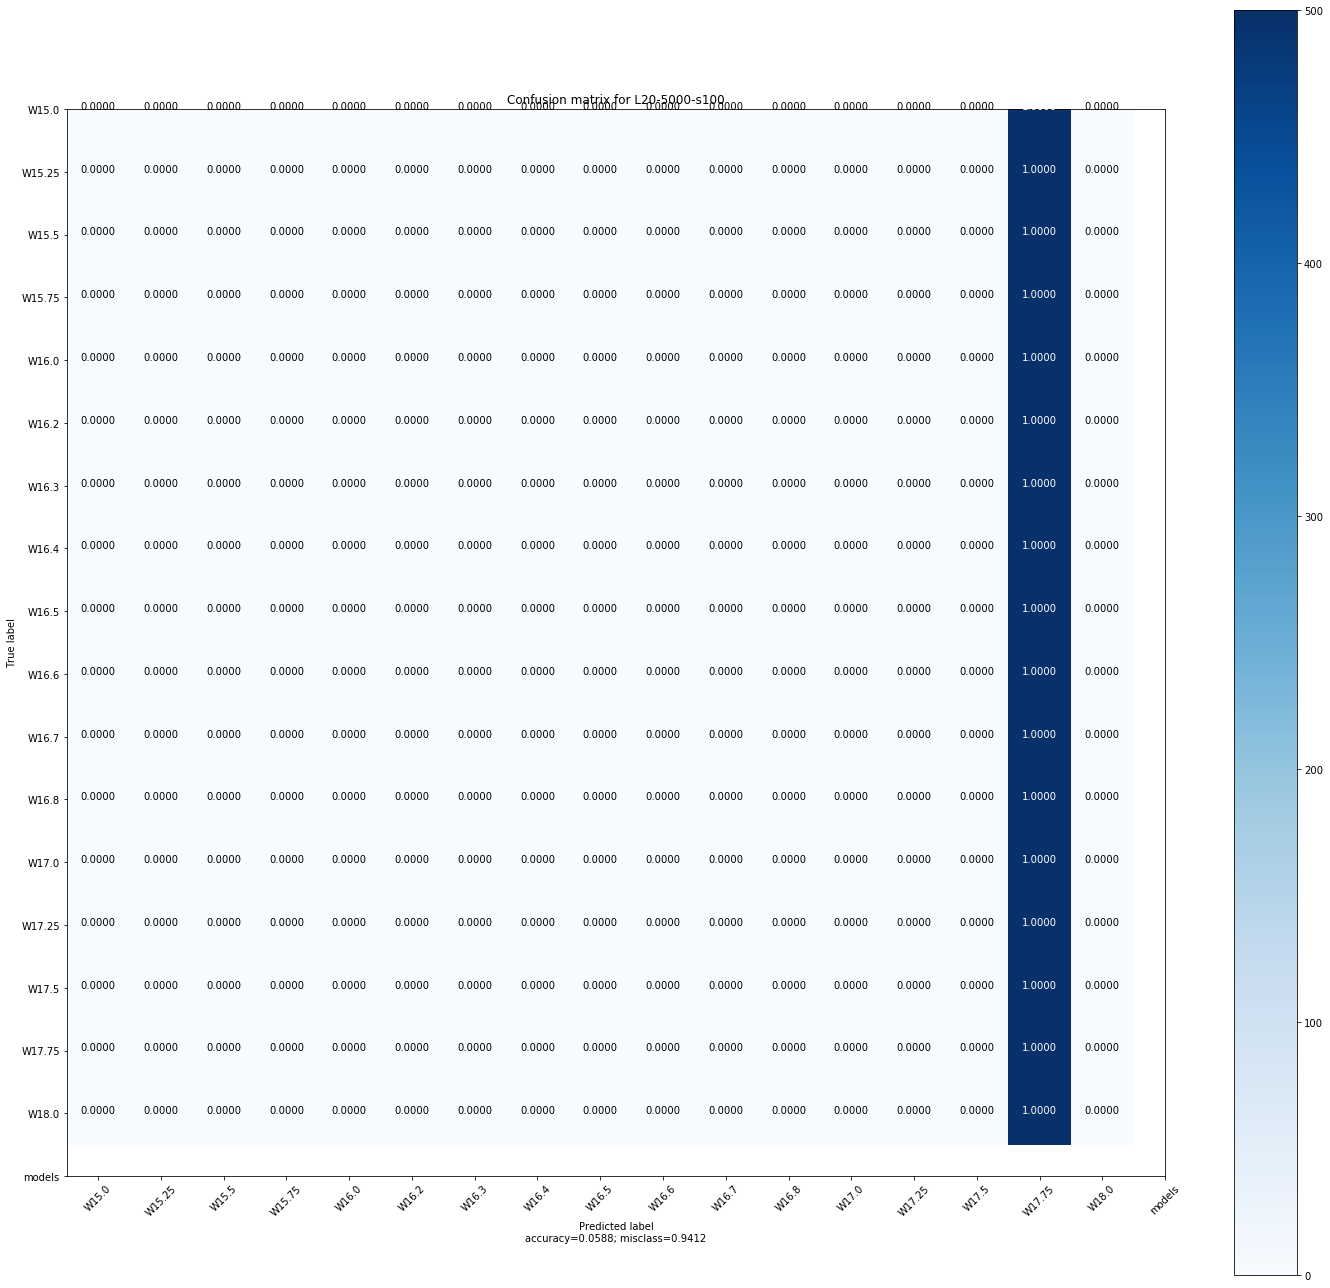

None


In [21]:
print(os.getcwd())
#os.chdir('../../../../PyCode/')
sys.path.insert(0,'../../../../PyCode/')
from plot_confusion_matrix import *

print(plot_confusion_matrix(confusion_matrix(validation_set.classes, y_pred),
                          label,savepath+'/'+method+'_'+dataname+'_cfm'+'.png',
                          title='Confusion matrix for '+dataname,
                          cmap=None,
                          normalize=True))
#os.chdir('../src/')

In [ ]:
%%javascript
IPython.notebook.save_notebook()